In [1]:
import os
import glob
import warnings
import h5py as h5
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from itertools import product
from tqdm.auto import tqdm
from copy import deepcopy

from gensit.config import Config
from gensit.inputs import Inputs
from gensit.outputs import Outputs
from gensit.utils.misc_utils import *
from gensit.utils.math_utils import *
from gensit.utils.probability_utils import *
from gensit.contingency_table import instantiate_ct
from gensit.contingency_table.MarkovBasis import instantiate_markov_basis
from gensit.static.plot_variables import LATEX_RC_PARAMETERS, COLOR_NAMES
from gensit.contingency_table.ContingencyTable_MCMC import ContingencyTableMarkovChainMonteCarlo

In [2]:
%matplotlib inline

# AUTO RELOAD EXTERNAL MODULES
%load_ext autoreload
%autoreload 2

In [3]:
# LaTeX font configuration
mpl.rcParams.update(LATEX_RC_PARAMETERS)

In [4]:
# Create new logging object
logger = setup_logger(
    __name__,
    console_level = 'INFO',
    file_level = 'EMPTY'
)

In [5]:
config = Config(
    "../../data/inputs/configs/DC/vanilla_comparisons.toml"
)
inputs = Inputs(
    config = config,
    synthetic_data = False,
    logger = logger
)
inputs.cast_to_xarray()
ground_truth_table = inputs.data.ground_truth_table

# Metrics

In [ ]:
# experiment_id = "JointTableSIM_NN_SweepedNoise__doubly_and_cell_constrained_29_05_2025_18_01_51_ensemble10"
# experiment_id = "NonJointTableSIM_NN_SweepedNoise__doubly_and_cell_constrained_29_05_2025_18_04_43_ensemble10"
lines = []
for experiment_id in [
    "NonJointTableSIM_NN_SweepedNoise__doubly_and_cell_constrained_29_05_2025_18_04_43_ensemble10"
    "JointTableSIM_NN_SweepedNoise__doubly_and_cell_constrained_29_05_2025_18_01_51_ensemble10",
]:

    method_name = "disjoint_gensit" if "NonJointTableSIM" in experiment_id else "joint_gensit"
    sample_names = ["table"]#["table","intensity"]
    sigmas = [0.1414213562, 0.0141421356, None]
    sample_sigma_combinations = list(product(sample_names, sigmas))


    method_out_path = f'../../data/outputs/DC/exp1/{experiment_id}/stored_results/'
    makedir(method_out_path)
    lines += [experiment_id]
    print(experiment_id,'\n')
    for sample,sigma in tqdm(sample_sigma_combinations,total=len(sample_sigma_combinations),desc='Computing metrics over sigmas and samples'):
        sigma_str = str(np.round(sigma,5) if sigma is not None else None)
        settings = {
            "logging_mode": "INFO",
            "coordinate_slice": [],
            "slice":False,
            "metadata_keys":[],
            "burnin_thinning_trimming": [],#{'iter': {"burnin":10000, "thinning":1, "trimming":100000}}
            "sample":[sample],
            "group_by":[],
            "filename_ending":"test",
            "force_reload":False,
            "n_workers": 1
            }
        # Initialise outputs
        method_outputs = Outputs(
            config = f'../../data/outputs/DC/exp1/{experiment_id}/config.json',
            settings = settings,
            inputs = None,
            slice = True,
            level = 'ERROR'
        )
        # Silence outputs
        method_outputs.logger.setLevels(console_level='ERROR')

        n_iter = method_outputs.config.get('N',None)
        all_seeds = method_outputs.config.get('seed',None)[:5]
        n_ensemble = len(all_seeds)
        print(f"{sample} E={n_ensemble}, N={n_iter}, sigma={sigma_str}")
        sweep_configs = deepcopy(method_outputs.config.sweep_configurations)
        print('Example sweep config',sweep_configs[0])

        method_srmses, method_ssis, method_cps = [],[],[]
        for seed in tqdm(all_seeds,total=len(all_seeds),desc='Computing metrics over seeds'):
            print(f"Seed {seed}")
            # Get sweep outputs
            method_outputs_copy = deepcopy(method_outputs)
            method_outputs_seed = method_outputs.get_sweep_outputs(
                base_config = method_outputs.config,
                # sweep_configuration=(seed, sigma, ['alpha', 'beta'], ['table_likelihood_loss'], ['custom'], {'nokey': None}),
                sweep_configuration = (seed,sigma,['alpha', 'beta']),
                sample_names = ['alpha','beta','log_destination_attraction'] if sample == 'intensity' else ['table'],
                group_by = [],
                index = 0
            )
            for sample_name,sample_data in method_outputs_seed.items():
                setattr(
                    method_outputs_copy.data,
                    sample_name,
                    [sample_data]
                )
            method_outputs_copy.stack_sweep_dims(method_outputs_copy)
            method_outputs_copy = method_outputs_copy.get(0)
            
            if sample == "intensity":
                method_sample = method_outputs_copy.get_sample('intensity')
                for d in ['sigma','seed','to_learn']:
                    if d in method_sample.dims:
                        method_sample = method_sample.squeeze(d)
            else:
                method_sample = method_outputs_copy.data.table
                for d in ['sigma','seed','to_learn']:
                    if d in method_sample.dims:
                        method_sample = method_sample.squeeze(d)
            
            method_srmse = srmse(
                prediction = method_sample.mean(['iter'],dtype='float64'),
                ground_truth = inputs.data.ground_truth_table,
                mask = inputs.data.test_cells_mask
            ).values
            method_srmses.append(method_srmse)
            method_ssi = ssi(
                prediction = method_sample.mean(['iter'],dtype='float64'),
                ground_truth = inputs.data.ground_truth_table,
                mask = inputs.data.test_cells_mask
            ).values
            method_ssis.append(method_ssi)
            method_cp = coverage_probability(
                prediction = method_sample,
                ground_truth = inputs.data.ground_truth_table,
                dim = 'iter',
                mask = inputs.data.test_cells_mask
            ).sum(['origin','destination'],skipna=True).values
            method_cps.append(method_cp)
            print(f"SRMSE: {method_srmse}")
            print(f"SSI: {method_ssi}")
            print(f"CP: {method_cp}")
            break

        lines += [
            f"{sample} E={n_ensemble}, N={n_iter}, sigma={sigma_str} ==============",
            f"SRMSE: mean={np.mean(method_srmses)}, std={np.std(method_srmses)}",
            f"SSI: mean={np.mean(method_ssis)}, std={np.std(method_ssis)}",
            f"CP: mean={np.mean(method_cps)}, std={np.std(method_cps)}",
            f"========================================================"
        ]
        
        with open('../../data/outputs/DC/exp1/summaries/experiments_doubly_cell_constrained_SRMSEs_SSIs_CPs.txt', mode='w', buffering=1, encoding='utf-8') as f:  # Line buffered
            for idx, line in enumerate(lines):
                f.write(line if line.endswith('\n') else line + '\n')
                f.flush()  # Ensure it's written
                os.fsync(f.fileno())

        break
    break


# GeNSIT (Disjoint)

In [ ]:
sample = "table"
reload = False

n_iter = 100000
n_ensemble = 10
seeds = range(1,n_ensemble+1)
sigma = 0.1414213562
#0.1414213562, None, 0.0141421356

# experiment_id = "NonJointTableSIM_NN_SweepedNoise__totally_and_cell_constrained_20_05_2024_15_57_08"
experiment_id = "NonJointTableSIM_NN_SweepedNoise__doubly_and_cell_constrained_29_05_2025_18_04_43_ensemble10"
disjointgensit_out_path = f'../../data/outputs/DC/exp1/{experiment_id}/stored_results/'
makedir(disjointgensit_out_path)
sigma_str = str(np.round(sigma,5) if sigma is not None else None)

In [ ]:
if sample == "intensity":
    settings = {
        "logging_mode": "INFO",
        "coordinate_slice": [
            f"da.sigma=={sigma_str}"
        ],
        "slice":True,
        "metadata_keys":[],
        "burnin_thinning_trimming": [],#{'iter': {"burnin":10000, "thinning":1, "trimming":100000}}
        "sample":[sample],
        "group_by":[],
        "filename_ending":"test",
        "force_reload":False,
        "n_workers": 1
    }
        
    disjointgensit_intensity_mean_path = os.path.join(disjointgensit_out_path,f'disjoint_gensit_{sample}_mean_E{n_ensemble}_N{n_iter}_sigma{sigma_str}.nc')
    if (not os.path.exists(disjointgensit_intensity_mean_path) or reload):
        # Initialise outputs
        disjointgensit_outputs = Outputs(
            config = f'../../data/outputs/DC/exp1/{experiment_id}/config.json',
            settings = settings,
            inputs = None,
            slice = True,
            level = 'ERROR'
        )
        # Silence outputs
        disjointgensit_outputs.logger.setLevels(console_level='NOTE')
        # Load all data
        disjointgensit_outputs.load()

        # Get data from first sweep of the experiment
        disjointgensit_outputs = disjointgensit_outputs.get(0)

        # Compute 
        disjointgensit_intensity_means = []
        for s in tqdm(disjointgensit_outputs.data.alpha.coords['seed'].values):
            disjointgensit_outputs_group = disjointgensit_outputs.select('seed',s)
            disjointgensit_intensity_group = disjointgensit_outputs_group.get_sample('intensity')
            disjointgensit_intensity_means.append(disjointgensit_intensity_group.mean(['iter'],dtype='float64'))
        disjointgensit_intensity_mean = xr.concat(
            disjointgensit_intensity_means, 
            dim='seed'
        ).reset_index('sweep')
        disjointgensit_intensity_mean.to_netcdf(path=disjointgensit_intensity_mean_path)
    elif os.path.exists(disjointgensit_intensity_mean_path):
        print('Loaded',disjointgensit_intensity_mean_path)
        disjointgensit_intensity_mean = xr.open_dataarray(disjointgensit_intensity_mean_path)

else:

    settings = {
        "logging_mode": "INFO",
        "coordinate_slice": [],
        "slice":False,
        "metadata_keys":[],
        "burnin_thinning_trimming": [],#{'iter': {"burnin":10000, "thinning":1, "trimming":100000}}
        "sample":[sample],
        "group_by":[],
        "filename_ending":"test",
        "force_reload":True,
        "n_workers": 1
    }
    disjointgensit_table_mean_path = os.path.join(disjointgensit_out_path,f'disjoint_gensit_{sample}_mean_E{n_ensemble}_N{n_iter}_sigma{sigma_str}.nc')

    if (not os.path.exists(disjointgensit_table_mean_path) or reload):
        disjointgensit_table_means = []
        for seed in tqdm(seeds):
            # Initialise outputs
            disjointgensit_outputs = Outputs(
                config = f'../../data/outputs/DC/exp1/{experiment_id}/config.json',
                settings = settings,
                inputs = None,
                slice = True,
                level = 'ERROR'
            )
            # Silence outputs
            disjointgensit_outputs.logger.setLevels(console_level='NOTE')
            # Slice sweep configurations
            print('BEFORE EDITTING',disjointgensit_outputs.config.sweep_configurations)
            disjointgensit_outputs.config.sweep_configurations = [(seed, sigma, ['alpha', 'beta'])]
            print('AFTER EDITTING',disjointgensit_outputs.config.sweep_configurations)
            # Load all data
            disjointgensit_outputs.load()

            # Get data from first sweep of the experiment
            disjointgensit_outputs = disjointgensit_outputs.get(0)
            
            # Compute mean and add it to list
            disjointgensit_table_means.append(disjointgensit_outputs.data.table.mean(['iter'],dtype='float64'))

        # Compute mean across seeds
        disjointgensit_table_mean = xr.concat(
            disjointgensit_table_means, 
            dim='seed'
        ).reset_index('sweep')
        disjointgensit_table_mean.to_netcdf(path=disjointgensit_table_mean_path)

    elif os.path.exists(disjointgensit_table_mean_path):
        print('Loaded',disjointgensit_table_mean_path)
        disjointgensit_table_mean = xr.open_dataarray(disjointgensit_table_mean_path)

In [ ]:
if 'disjointgensit_table_mean' in globals():
    disjointgensit_table_srmses = disjointgensit_table_mean.groupby('seed').map(
        srmse,
        ground_truth = inputs.data.ground_truth_table,
        mask = inputs.data.test_cells_mask
    ).values
    print('disjointgensit_table_mean srmes',np.mean(disjointgensit_table_srmses),np.std(disjointgensit_table_srmses))
if 'disjointgensit_intensity_mean' in globals():
    disjointgensit_intensity_srmses = disjointgensit_intensity_mean.groupby('seed').map(
        srmse,
        ground_truth = inputs.data.ground_truth_table,
        mask = inputs.data.test_cells_mask
    ).values
    print('disjointgensit_intensity_srmses srmes',np.mean(disjointgensit_intensity_srmses),np.std(disjointgensit_intensity_srmses))

# GeNSIT (Joint)

In [ ]:
sample = "table"
reload = False

n_iter = 100000
n_ensemble = 5
seeds = range(1,n_ensemble+1)
# None,range(1,n_ensemble+1)
sigma = 0.1414213562
#0.1414213562, None, 0.0141421356

experiment_id = 'JointTableSIM_NN_SweepedNoise__doubly_and_cell_constrained_29_05_2025_15_05_34_ensemble5'
# experiment_id = 'JointTableSIM_NN_SweepedNoise__totally_and_cell_constrained_28_05_2025_19_41_33_ensemble5'
jointgensit_out_path = f'../../data/outputs/DC/exp1/{experiment_id}/stored_results/'
makedir(jointgensit_out_path)
sigma_str = str(np.round(sigma,5) if sigma is not None else None)

In [ ]:
if sample == "intensity":
    settings = {
        "logging_mode": "INFO",
        "coordinate_slice": [
            f"da.sigma=={sigma_str}"
        ],
        "slice":True,
        "metadata_keys":[],
        "burnin_thinning_trimming": [],#{'iter': {"burnin":10000, "thinning":1, "trimming":100000}}
        "sample":[sample],
        "group_by":[],
        "filename_ending":"test",
        "force_reload":False,
        "n_workers": 1
    }

    jointgensit_intensity_mean_path = os.path.join(jointgensit_out_path,f'joint_gensit_{sample}_mean_E{n_ensemble}_N{n_iter}_sigma{sigma_str}.nc')
    if (not os.path.exists(jointgensit_intensity_mean_path) or reload):
        # Initialise outputs
        jointgensit_outputs = Outputs(
            config = f'../../data/outputs/DC/exp1/{experiment_id}/config.json',
            settings = settings,
            inputs = None,
            slice = True,
            level = 'NOTE'
        )
        # Silence outputs
        jointgensit_outputs.logger.setLevels(console_level='NOTE')
        # Load all data
        jointgensit_outputs.load()

        # Get data from first sweep of the experiment
        jointgensit_outputs = jointgensit_outputs.get(0)

        # Compute 
        jointgensit_intensity_means = []
        for s in tqdm(jointgensit_outputs.data.alpha.coords['seed'].values):
            jointgensit_outputs_group = jointgensit_outputs.select('seed',s)
            jointgensit_intensity_group = jointgensit_outputs_group.get_sample('intensity')
            jointgensit_intensity_means.append(jointgensit_intensity_group.mean(['iter'],dtype='float64'))
        jointgensit_intensity_mean = xr.concat(
            jointgensit_intensity_means, 
            dim='seed'
        ).reset_index('sweep')
        jointgensit_intensity_mean.to_netcdf(path=jointgensit_intensity_mean_path)
    elif os.path.exists(jointgensit_intensity_mean_path):
        print('Loaded',jointgensit_intensity_mean_path)
        jointgensit_intensity_mean = xr.open_dataarray(jointgensit_intensity_mean_path)

else:

    settings = {
        "logging_mode": "INFO",
        "coordinate_slice": [],
        "slice":False,
        "metadata_keys":[],
        "burnin_thinning_trimming": [],#{'iter': {"burnin":10000, "thinning":1, "trimming":100000}}
        "sample":[sample],
        "group_by":[],
        "filename_ending":"test",
        "force_reload":True,
        "n_workers": 1
    }
    jointgensit_table_mean_path = os.path.join(jointgensit_out_path,f'joint_gensit_{sample}_mean_E{n_ensemble}_N{n_iter}_sigma{sigma_str}.nc')

    if (not os.path.exists(jointgensit_table_mean_path) or reload):
        jointgensit_table_means = []
        for seed in tqdm(seeds):
            # Initialise outputs
            jointgensit_outputs = Outputs(
                config = f'../../data/outputs/DC/exp1/{experiment_id}/config.json',
                settings = settings,
                inputs = None,
                slice = True,
                level = 'NOTE'
            )
            # Silence outputs
            jointgensit_outputs.logger.setLevels(console_level='NOTE')
            # Slice sweep configurations
            print(jointgensit_outputs.config.sweep_configurations)
            jointgensit_outputs.config.sweep_configurations = [(seed,sigma, ['alpha', 'beta'])]
            # Load all data
            jointgensit_outputs.load()

            # Get data from first sweep of the experiment
            jointgensit_outputs = jointgensit_outputs.get(0)
            
            # Compute mean and add it to list
            jointgensit_table_means.append(jointgensit_outputs.data.table.mean(['iter'],dtype='float64'))

        # Compute mean across seeds
        jointgensit_table_mean = xr.concat(
            jointgensit_table_means, 
            dim='seed'
        ).reset_index('sweep')
        jointgensit_table_mean.to_netcdf(path=jointgensit_table_mean_path)

    elif os.path.exists(jointgensit_table_mean_path):
        print('Loaded',jointgensit_table_mean_path)
        jointgensit_table_mean = xr.open_dataarray(jointgensit_table_mean_path)

In [ ]:
if 'jointgensit_table_mean' in globals():
    jointgensit_table_srmses = jointgensit_table_mean.groupby('seed').map(
        srmse,
        ground_truth = inputs.data.ground_truth_table,
        mask = inputs.data.test_cells_mask
    ).values
    print("jointgensit_table_srmses",np.mean(jointgensit_table_srmses),np.std(jointgensit_table_srmses))

    joint_gensit_table_relative_l1_error = relative_l_1(
        prediction=jointgensit_table_mean,
        ground_truth=ground_truth_table,
        mask=inputs.data.test_cells_mask,
    )
    print('Joint Gensit table: mean relative l1',joint_gensit_table_relative_l1_error.mean(['origin','destination','seed'],dtype='float64').values)

    joint_gensit_table_relative_colsum_l1_error = mean_absolute_residual_percentage_error(
        prediction=jointgensit_table_mean,
        ground_truth=ground_truth_table,
        mask=inputs.data.test_cells_mask,
        dim='origin'
    )
    joint_gensit_table_relative_rowsum_l1_error = mean_absolute_residual_percentage_error(
        prediction=jointgensit_table_mean,
        ground_truth=ground_truth_table,
        mask=inputs.data.test_cells_mask,
        dim='destination'
    )

if 'jointgensit_intensity_mean' in globals():
    jointgensit_intensity_srmses = jointgensit_intensity_mean.groupby('seed').map(
        srmse,
        ground_truth = inputs.data.ground_truth_table,
        mask = inputs.data.test_cells_mask
    ).values
    print("jointgensit_intensity_srmses",np.mean(jointgensit_intensity_srmses),np.std(jointgensit_intensity_srmses))

    joint_gensit_intensity_relative_l1_error = relative_l_1(
        prediction=jointgensit_intensity_mean,
        ground_truth=ground_truth_table,
        mask=inputs.data.test_cells_mask,
    )
    print('Joint Gensit intensity: mean relative l1',joint_gensit_intensity_relative_l1_error.mean(['origin','destination','seed'],dtype='float64').values)

    joint_gensit_intensity_relative_colsum_l1_error = mean_absolute_residual_percentage_error(
        prediction=jointgensit_intensity_mean,
        ground_truth=ground_truth_table,
        mask=inputs.data.test_cells_mask,
        dim='origin'
    )
    joint_gensit_intensity_relative_rowsum_l1_error = mean_absolute_residual_percentage_error(
        prediction=jointgensit_intensity_mean,
        ground_truth=ground_truth_table,
        mask=inputs.data.test_cells_mask,
        dim='destination'
    )

In [ ]:
min(joint_gensit_table_relative_colsum_l1_error.values),max(joint_gensit_table_relative_colsum_l1_error.values),sum(joint_gensit_table_relative_colsum_l1_error.values)

# SIM_NN

In [ ]:
reload = False

n_iter = 100000
n_ensemble = 10
seeds = range(1,11)
sigma = 0.1414213562
#0.1414213562, None, 0.0141421356

experiment_id = 'SIM_NN_SweepedNoise__totally_and_cell_constrained_20_05_2024_15_59_08'
sim_nn_out_path = f'../../data/outputs/DC/exp1/{experiment_id}/stored_results/'
makedir(sim_nn_out_path)
sigma_str = str(np.round(sigma,5) if sigma is not None else None)

In [ ]:
sim_nn_intensity_mean_path = os.path.join(sim_nn_out_path,f'sim_nn_intensity_mean_E{n_ensemble}_N{n_iter}_sigma{sigma_str}.nc')
if (not os.path.exists(sim_nn_intensity_mean_path) or reload):
    settings = {
        "logging_mode": "INFO",
        "coordinate_slice": [
            f"da.sigma=={sigma_str}"
        ],
        "slice":True,
        "metadata_keys":[],
        "burnin_thinning_trimming": [],#{'iter': {"burnin":10000, "thinning":1, "trimming":100000}}
        "sample":["intensity"],
        "group_by":[],
        "filename_ending":"test",
        "force_reload":False,
        "n_workers": 1
    }
    # Initialise outputs
    sim_nn_outputs = Outputs(
        config = f'../../data/outputs/DC/exp1/{experiment_id}/config.json',
        settings = settings,
        inputs = None,
        slice = True,
        level = 'NOTE'
    )
    # Silence outputs
    sim_nn_outputs.logger.setLevels(console_level='NOTE')
    # Load all data
    sim_nn_outputs.load()

    # Get data from first sweep of the experiment
    sim_nn_outputs = sim_nn_outputs.get(0)

    # Compute 
    sim_nn_intensity_means = []
    for s in tqdm(sim_nn_outputs.data.alpha.coords['seed'].values):
        sim_nn_outputs_group = sim_nn_outputs.select('seed',s)
        sim_nn_intensity_group = sim_nn_outputs_group.get_sample('intensity')
        sim_nn_intensity_means.append(sim_nn_intensity_group.mean(['iter'],dtype='float64'))
    sim_nn_intensity_mean = xr.concat(
        sim_nn_intensity_means, 
        dim='seed'
    ).reset_index('sweep')
    sim_nn_intensity_mean.to_netcdf(path=sim_nn_intensity_mean_path)
    sim_nn_intensity_mean = sim_nn_intensity_mean.squeeze('sweep')
elif os.path.exists(sim_nn_intensity_mean_path):
    print('Loaded',sim_nn_intensity_mean_path)
    sim_nn_intensity_mean = xr.open_dataarray(sim_nn_intensity_mean_path)
    sim_nn_intensity_mean = sim_nn_intensity_mean.squeeze('sweep')

In [ ]:
if 'sim_nn_intensity_mean' in globals():
    sim_nn_intensity_srmses = sim_nn_intensity_mean.groupby('seed').map(
        srmse,
        ground_truth = inputs.data.ground_truth_table,
        mask = inputs.data.test_cells_mask
    ).values

    sim_nn_relative_l1_error = relative_l_1(
        prediction=sim_nn_intensity_mean,
        ground_truth=ground_truth_table,
        mask=inputs.data.test_cells_mask,
    )
    print('SIM NN intensity: mean relative l1',sim_nn_relative_l1_error.mean(['origin','destination','seed'],dtype='float64').values)

    sim_nn_relative_colsum_l1_error = mean_absolute_residual_percentage_error(
        prediction=sim_nn_intensity_mean,
        ground_truth=ground_truth_table,
        mask=inputs.data.test_cells_mask,
        dim='origin'
    )
    sim_nn_relative_rowsum_l1_error = mean_absolute_residual_percentage_error(
        prediction=sim_nn_intensity_mean,
        ground_truth=ground_truth_table,
        mask=inputs.data.test_cells_mask,
        dim='destination'
    )


In [ ]:
min(sim_nn_relative_colsum_l1_error.values),max(sim_nn_relative_colsum_l1_error.values),sum(sim_nn_relative_colsum_l1_error.values)

# GMEL

In [ ]:
reload = False
n_iter = 10000
n_ensemble = 10 

experiment_id = 'GraphAttentionNetwork_Comparison_UnsetNoise__doubly_and_cell_constrained_all_region_features_16_05_2024_21_06_14'
gmel_out_path = f'../../data/outputs/DC/comparisons/{experiment_id}/stored_results/'
makedir(gmel_out_path)

In [ ]:
gmel_intensity_mean_path = f'../../data/outputs/DC/comparisons/{experiment_id}/stored_results/gmel_intensity_mean_E{n_ensemble}_N{n_iter}.nc'
if (not os.path.exists(gmel_intensity_mean_path) or reload):
    gmel_settings = {
        "logging_mode": "INFO",
        "coordinate_slice": [
            # "da.seed==1"
        ],
        "slice":False,
        "metadata_keys":[],
        "burnin_thinning_trimming": [],
        "sample":["intensity"],
        "group_by":[],
        "filename_ending":"test",
        "force_reload":False,
        "n_workers": 1
    }

    # Initialise outputs
    gmel_outputs = Outputs(
        config = f'../../data/outputs/DC/comparisons/{experiment_id}/config.json',
        settings = gmel_settings,
        inputs = None,
        slice = True,
        level = 'NOTE'
    )
    # Silence outputs
    gmel_outputs.logger.setLevels(console_level='NOTE')
    # Load all data
    gmel_outputs.load()

    # Get data from first sweep of the experiment
    gmel_outputs = gmel_outputs.get(0)

    makedir(os.path.dirname(gmel_intensity_mean_path))
    gmel_intensity_mean = gmel_outputs.data.intensity.mean(['iter'],dtype='float64')
    gmel_intensity_mean.to_netcdf(path=gmel_intensity_mean_path)
else:
    gmel_intensity_mean = xr.open_dataarray(gmel_intensity_mean_path)

In [ ]:
if 'gmel_intensity_mean' in globals():
    gmel_srmses = gmel_intensity_mean.groupby('seed').apply(
        srmse,
        ground_truth = inputs.data.ground_truth_table,
        mask = inputs.data.test_cells_mask
    ).values

    gmel_relative_l1_error = relative_l_1(
        prediction=gmel_intensity_mean,
        ground_truth=ground_truth_table,
        mask=inputs.data.test_cells_mask,
    )
    print('GMEL intensity: mean relative l1',gmel_relative_l1_error.mean(['origin','destination','seed'],dtype='float64').values)

    gmel_relative_colsum_l1_error = mean_absolute_residual_percentage_error(
        prediction=gmel_intensity_mean,
        ground_truth=ground_truth_table,
        mask=inputs.data.test_cells_mask,
        dim='origin'
    )
    gmel_relative_rowsum_l1_error = mean_absolute_residual_percentage_error(
        prediction=gmel_intensity_mean,
        ground_truth=ground_truth_table,
        mask=inputs.data.test_cells_mask,
        dim='destination'
    )


In [ ]:
min(gmel_relative_colsum_l1_error.values),max(gmel_relative_colsum_l1_error.values),sum(gmel_relative_colsum_l1_error.values)

# Plots

In [ ]:
for sum_dim in ['origin','destination']:
    region_geometries = getattr(inputs.data,'region_geometries')

    if sum_dim == 'destination':
        plot_dim = 'origin'
        gmel_quantity = gmel_relative_rowsum_l1_error
        sim_nn_quantity = sim_nn_relative_rowsum_l1_error
        joint_gensit_quantity = joint_gensit_table_relative_rowsum_l1_error

    elif sum_dim == 'origin':
        plot_dim = 'destination'
        gmel_quantity = gmel_relative_colsum_l1_error
        sim_nn_quantity = sim_nn_relative_colsum_l1_error
        joint_gensit_quantity = joint_gensit_table_relative_colsum_l1_error

    min_error = min(np.min(gmel_quantity.values),np.min(sim_nn_quantity.values),np.min(joint_gensit_quantity.values))
    max_error = max(np.max(gmel_quantity.values),np.max(sim_nn_quantity.values),np.max(joint_gensit_quantity.values))

    if 'joint_gensit_quantity' in globals():
        print(f"Joint GeNSIT min error: {np.min(joint_gensit_quantity.values)} max error: {np.max(joint_gensit_quantity.values)} total error: {np.sum(joint_gensit_quantity.values)}")
    if 'sim_nn_quantity' in globals():
        print(f"SIM NN min error: {np.min(sim_nn_quantity.values)} max error: {np.max(sim_nn_quantity.values)} total error: {np.sum(sim_nn_quantity.values)}")
    if 'gmel_quantity' in globals():
        print(f"GMEL min error: {np.min(gmel_quantity.values)} max error: {np.max(gmel_quantity.values)} total abs error: {np.sum(gmel_quantity.values)}")

    gmel_quantity_with_geometries = pd.merge(
        gmel_quantity.to_pandas().reset_index().rename(columns={0:"error"}),
        region_geometries[['LOCATIONID','geometry']],
        how = 'left',
        left_on = plot_dim,
        right_on = 'LOCATIONID'
    ) 
    # Convert back to geodataframe
    gmel_quantity_with_geometries = gpd.GeoDataFrame(gmel_quantity_with_geometries.drop(columns=['LOCATIONID']))

    joint_gensit_quantity_with_geometries = pd.merge(
        joint_gensit_quantity.to_pandas().reset_index().rename(columns={0:"error"}),
        region_geometries[['LOCATIONID','geometry']],
        how = 'left',
        left_on = plot_dim,
        right_on = 'LOCATIONID'
    ) 
    # Convert back to geodataframe
    joint_gensit_quantity_with_geometries = gpd.GeoDataFrame(joint_gensit_quantity_with_geometries.drop(columns=['LOCATIONID']))


    sim_nn_quantity_with_geometries = pd.merge(
        sim_nn_quantity.to_pandas().reset_index().rename(columns={0:"error"}),
        region_geometries[['LOCATIONID','geometry']],
        how = 'left',
        left_on = plot_dim,
        right_on = 'LOCATIONID'
    ) 
    # Convert back to geodataframe
    sim_nn_quantity_with_geometries = gpd.GeoDataFrame(sim_nn_quantity_with_geometries.drop(columns=['LOCATIONID']))

    # Plot settings
    plot_settings = {
        "figure_size":(10,10),
        "colourmap":"Reds",
        "figure_format":"ps",
        "figure_title":"figure5/mean_residual",
        "legend_axis":[0,0],
        "axis_title_size":30,
        
        "x_label":"Longitude",
        "x_label_size":18,
        "x_label_pad":7,
        "x_tick_size":16,
        "x_tick_rotation":None,
        "x_tick_pad":5,
        "x_label_rotation":0,
        
        "y_label":"Latitude",
        "y_label_size":18,
        "y_label_pad":7,
        "y_tick_size":16,
        "y_tick_rotation":None,
        "y_tick_pad":5,
        "y_label_rotation":90,
        
        "vmin":0.08,#min_error,
        "vmax":28,#max_error,
        "colourbar":False
    }

    for model,data in [
        ("GMEL",gmel_quantity_with_geometries),
        ("SIM NN",sim_nn_quantity_with_geometries),
        ("GeNSIT (Joint)",joint_gensit_quantity_with_geometries),
        
    ]:
        
        print(f"Compiling figure for {model} over {plot_dim}s")
        # Figure size 
        fig, ax = plt.subplots(
            figsize = plot_settings.get('figure_size',None),
            ncols = 1,
            nrows = 1,
            squeeze = False
        )

        # Set colormap
        cmap = plt.get_cmap(plot_settings.get('colourmap',None))
        norm = mpl.colors.LogNorm(vmin=plot_settings["vmin"], vmax=plot_settings["vmax"])

        # Global axes label
        for var in ['x','y']:
            if plot_settings.get(f'{var}_label',''):
                axis_label = plot_settings[f'{var}_label'].replace("_"," ")
                getattr(plt,f"{var}label",plt.xlabel)(
                    axis_label,
                    fontsize = plot_settings.get(f'{var}_label_size',None),
                    labelpad = plot_settings.get(f'{var}_label_pad',None),
                    rotation = plot_settings.get(f'{var}_label_rotation',None)
                )
                ax[0,0].tick_params(
                    axis = var, 
                    pad = plot_settings.get(f"{var}_tick_pad",None),
                    bottom = True,
                    labelsize = plot_settings.get(f"{var}_tick_size",None),
                    rotation = plot_settings.get(f"{var}_tick_rotation",None)
                )
        ax[0,0] = data.plot(
                column = 'error',
                ax = ax[0,0],
                alpha = 1,
                markersize = 2.0,
                linewidth=2, 
                edgecolor='black',
                cmap = cmap,
                # norm = mpl.colors.Normalize(vmin=plot_settings["vmin"], vmax=plot_settings["vmax"]),
                norm = norm,
                legend = plot_settings['colourbar']
            )
        # ax[0,0].set_title(
        #     model,
        #     fontdict = {'fontsize':plot_settings.get('axis_title_size',None)}
        # )
        if sum_dim == 'origin':
            text_loc = (0.7, 0.87)
        else:
            text_loc = (0.8, 0.87)
        fig.text(
            text_loc[0], text_loc[1], f"Mean abs. \% error: {np.round(data.error.mean(),1)}", 
            ha='right', va='top', fontsize=22, 
            bbox=dict(facecolor='none', edgecolor='none', alpha=0)
        )
        ax[0,0].tick_params(labelsize=plot_settings['x_tick_size'])
        if len(ax[0,0].get_figure().get_axes()) > 1:
            # Access the colorbar
            cbar = ax[0,0].get_figure().get_axes()[1]
            # Set the fontsize of the colorbar
            cbar.tick_params(labelsize=plot_settings['x_tick_size'])

        write_figure(
            fig,
            f"../../data/outputs/DC/exp1/paper_figures/residuals/{model}_{plot_dim}",
            figure_format=plot_settings.get('figure_format',''),
            pad_inches=0.0,
            bbox_inches='tight'
        )

    # Create a separate figure for horizontal colorbar
    fig_cbar, ax_cbar = plt.subplots(figsize=(8, 1))  # Wide and short

    print(f'{sum_dim} sum','vmin',plot_settings['vmin'],'vmax',plot_settings['vmax'])
    # Use same colormap and normalization as main plot
    sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # Required for colorbar creation in older versions

    # Create horizontal colorbar
    cbar = fig_cbar.colorbar(sm, cax=ax_cbar, orientation='horizontal')
    cbar.ax.tick_params(labelsize=plot_settings['x_tick_size'])

    # Optional: customize labels or add title
    # cbar.set_label("Error Value", fontsize=14)

    # Clean layout
    fig_cbar.tight_layout()

    write_figure(
        fig_cbar,
        f"../../data/outputs/DC/exp1/paper_figures/residuals/{plot_dim}_colorbar",
        figure_format=plot_settings.get('figure_format',''),
        pad_inches=0.0,
        bbox_inches='tight'
    )

In [ ]:
# Sanity check
(inputs.data.train_cells.shape[0] + \
inputs.data.test_cells.shape[0] + \
inputs.data.validation_cells.shape[0]) \
== \
ground_truth_table.shape[0]*ground_truth_table.shape[1]

Total test destinations 179
Total test origins 43


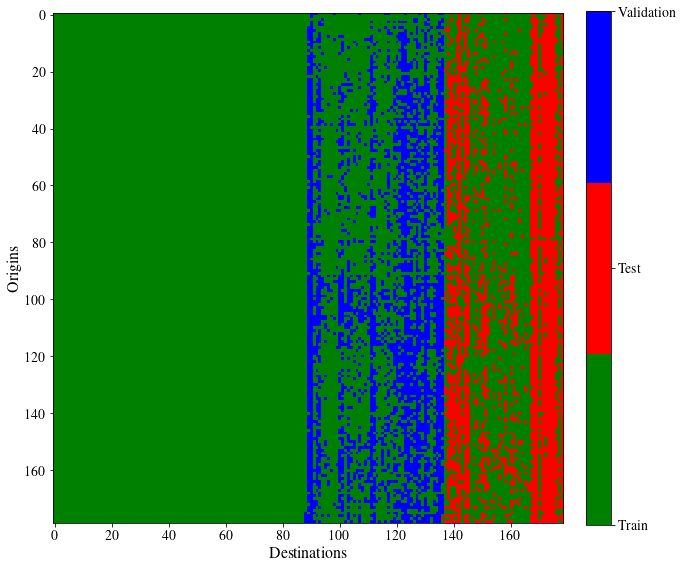

In [11]:
# Plot train / test / validation split
table_masks = deepcopy(ground_truth_table)
table_masks[:] = 0
table_masks += inputs.data.train_cells_mask.astype(int)
table_masks += 2*inputs.data.test_cells_mask.astype(int)
table_masks += 3*inputs.data.validation_cells_mask.astype(int)

new_destinations = np.where(np.all(table_masks == 2, axis=0))[0]
new_origins = np.where(np.all(table_masks == 2, axis=1))[0]
# print('new destinations',new_destinations)
# print('new origins',new_origins)
print("Total test destinations",len(np.unique(inputs.data.test_cells[:,0])))
print("Total test origins",len(np.unique(inputs.data.test_cells[:,1])))

test_cells_df = pd.DataFrame(inputs.data.test_cells.astype(int), columns=["origin", "destination"])
# Count unique values in column 2 (value) per unique value in column 1 (key)
# print("Total test origins by test destination",test_cells_df.groupby("origin")["destination"].nunique())
# print("Total test destinations by test origin",test_cells_df.groupby("destination")["origin"].nunique())

fig,ax = plt.subplots(1,1,figsize=(10, 10))
colors = ['green', 'red', 'blue']
cmap = mpl.colors.ListedColormap(colors)
heatmap = plt.imshow(table_masks, cmap=cmap, aspect='equal', interpolation='nearest')
cbar = plt.colorbar(ticks=[1, 2, 3],fraction=0.046, pad=0.04)
cbar.set_ticklabels(['Train', 'Test', 'Validation'])
cbar.ax.tick_params(labelsize=14)
# ax.set_xticks([])
# ax.set_yticks([])
ax.tick_params(axis='both', labelsize=14)
ax.set_xlabel('Destinations', fontsize=16)
ax.set_ylabel('Origins', fontsize=16)
# fig.tight_layout()
plt.show()

fig.savefig(
    f"../../data/outputs/DC/exp1/paper_figures/train_test_split/train_test_validation_split.pdf",
    format='pdf'
)
# write_figure(
#     fig,
#     f"../../data/outputs/DC/exp1/paper_figures/train_test_split/train_test_validation_split",
#     figure_format=plot_settings.get('figure_format',''),
#     pad_inches=0.0,
#     bbox_inches='tight'
# )

In [ ]:
# fig,ax = plt.subplots(1,1,figsize=(10, 10))
# plt.title('New destinations')
# region_geometries.boundary.plot(ax=ax)
# region_geometries[region_geometries.LOCATIONID.isin(new_destinations)].plot(ax=ax,color='red', edgecolor='black')
# plt.show()

# Statistical significance

In [ ]:
print('GMEL',np.mean(gmel_srmses),np.std(gmel_srmses))
# print('SIM_NN',np.mean(sim_nn_intensity_srmses),np.std(sim_nn_intensity_srmses))
print('Joint GeNSIT',np.mean(jointgensit_table_srmses),np.std(jointgensit_table_srmses))

In [ ]:
# HO: mean(Joint GeNSIT SRMSE) >= mean(GMEL SRMSE)
perform_one_tailed_ttest(
    sample_a_name='GeNSIT (Joint) SRMSE',
    sample_a=jointgensit_table_srmses,
    sample_b_name='GMEL SRMSE',
    sample_b=gmel_srmses,
)

In [ ]:
perform_one_tailed_ttest_using_summaries(
    name1 = 'GeNSIT (Joint) SRMSE',
    mean1 = np.mean(jointgensit_table_srmses),
    std1 = np.std(jointgensit_table_srmses),
    n1=20,
    name2 = 'GMEL SRMSE',
    mean2 = np.mean(gmel_srmses), 
    std2 = np.std(gmel_srmses),
    n2=20,
)